<img src="https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/agods/nyp_ago_logo.png" width='400'/>

# Practical: End-to-end Machine Learning Process

In this lab, we will go through end-to-end process of building a regression model to predict housing prices.

At the end of the session, you will learn how to:


1.   Perform exploratary data analysis
2.   Perform data preparation
3.   Train and validate model
4.   Fine Tune Model
5.   Test the model

## Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

## Getting the data

We will be using the California housing Prices dataset.  This dataset was based on data from the 1990 California census. You can see a description of the data here: 
https://www.kaggle.com/datasets/camnugent/california-housing-prices


In [2]:
import pandas as pd

df = pd.read_csv('data/housing.csv')

## Understanding the data

As in all Machine Learning project, it is important to have a good understanding of your data. We will be doing some exploratory data analysis as our next step. But before we delve further into it, let's just take a quick look at our data.  We can first examine some samples, using `Dataframe.head()`

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The `info()` method is useful to get a quick description of the data, in particular the total number of rows, each attribute’s type, and the number of non-null values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**Question**

1. How many samples we have?
2. Do we have any missing values? Which feature(s) have missing values? 
3. Which feature(s) is a categorical feature?

<details><summary>Click here for answer</summary>

1. 20640 samples in total
2. Yes, we have missing values. The samples have 207 missing 'total_bedrooms' values.
3. ocean_proximity is a categorical value, which has 'object' as its data type

The `describe()` method shows a summary of the numerical attributes. 

In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute.

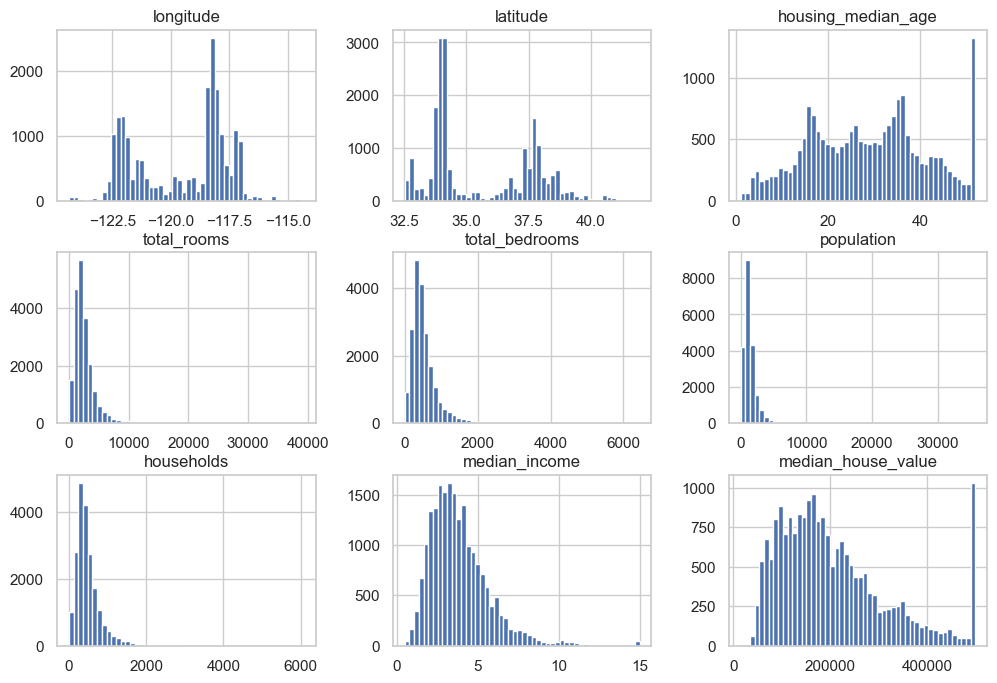

In [6]:
sns.set_theme(style='whitegrid')
df.hist(bins=50, figsize=(12, 8))
plt.show()

You noticed that some attributes have a skewed-right distribution, so you may want to transform them (e.g.,
by computing their logarithm) when preparing data later on.

**Question** 

What do you notice from the histogram plot about median housing value? Will there be potential problem? 

<details><summary>Click here for answer</summary> 
    
The histogram shows a large count of houses at the maximum price.  This is due to the way the data is collected, for example, housing prices are capped at a maximum value (e.g. 500,001)

This may be a serious problem since it is your target attribute (your labels). Your machine learning algorithms may learn that prices never go beyond that limit. If you need to predict values beyond $500,001, then you should collect proper labels for the districts whose labels are capped. Or you can remove those districts from the training and test set.
    
</details>

In [7]:
len(df[df['median_house_value']==500001.0])

965

## Splitting Data into Train and Test Set 
Before we proceed with more data exploration, it is often a good practice for us to first set aside a part of our dataset as test set, so as to prevent us from snooping information/pattern from the test set and 'overfit' ourselves (and eventually our model) to the test set.

We can either random shuffle the data and split them into train/test split using scikit-learn's `train_test_split()` method, e.g. 

```
train_set, test_set = train_test_split(df, 0.2)
```

This is
generally fine if your dataset is large enough (especially relative to the
number of attributes), but if it is not, you run the risk of introducing a
significant sampling bias.  Your train set may not have a representative distribution as your eventual test set or real-world data. 

If based on the domain experts inputs, who feel that income distribution is a key for good prediction, we want to make sure our train and test set has the same income distribution. So we may want to split in such a way that train/test set has same distribution of income categories, e.g. This can be done by stratified sampling.

Before that let's take a closer look at the income distribution using histogram


<AxesSubplot: xlabel='median_income', ylabel='Count'>

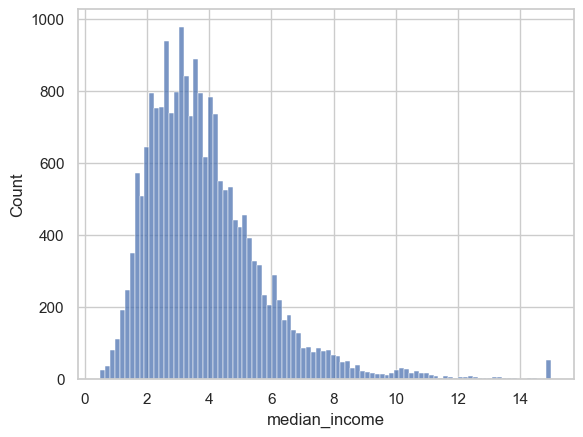

In [8]:
# plt.hist(df.median_income)
sns.histplot(data=df, x='median_income')

**Creating income categories**


Most median income values are clustered around 1.5 to 6 (i.e.,  \\$15,000 to \\$60,000), but some
median incomes go far beyond 6. It is important to have a sufficient number
of instances in your dataset for each stratum, or else the estimate of a
stratum’s importance may be biased. This means that you should not have too
many strata, and each stratum should be large enough. 

We can use the [`pd.cut()`](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) to bin the median income into 5 categories (e.g. $[0, 1.5], [1.5, 3.0], [3.0, 4.5], [4.5, 6]$ and $[6, \infty]$).

In [9]:
df["income_cat"] = pd.cut(df["median_income"],
                          bins=[0., 1.5, 3.0, 4.5, 6., 7.5, 9, np.inf], 
                          labels=[1, 2, 3, 4, 5, 6, 7])

Let us find out the number of samples for each categories 1, 2, ... 5.

In [10]:
df["income_cat"].value_counts().sort_index()

1     822
2    6581
3    7236
4    3639
5    1423
6     532
7     407
Name: income_cat, dtype: int64

<AxesSubplot: >

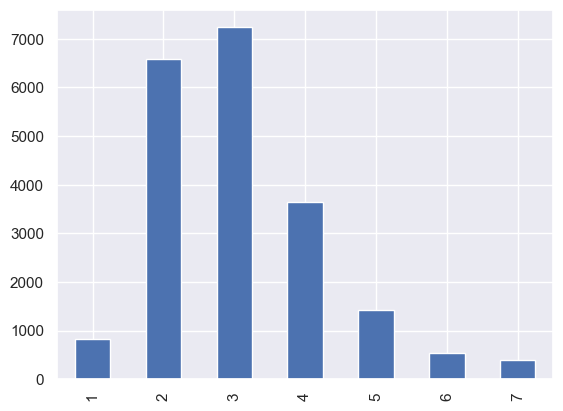

In [11]:
sns.set_theme()
df["income_cat"].value_counts().sort_index().plot.bar()

### Using Stratified Sampling to Split data 

Stratified random sampling is a method of sampling that involves the division of a population into smaller sub-groups known as strata. In stratified random sampling, the strata are formed based on members' shared attributes or characteristics such as income or educational attainment.  The following code shows you how we can use Stratified Sampling to split the data into training and testing set. 

In [12]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(df, shuffle=True, 
                                                   stratify=df['income_cat'], 
                                                   random_state=42)

In the code cell below, we will compute and display the percentage of each income categories for 'Stratified' and 'Random' splitted data.

In [13]:
def income_cat_props(data):
    # compute the percentage of data across different categories
    return data['income_cat'].value_counts()/len(data)

rand_train_set, rand_test_set = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

compare_props = pd.DataFrame({
    'Overall': income_cat_props(df),
    'Stratified': income_cat_props(strat_test_set),
    'Random': income_cat_props(rand_test_set)
}).sort_index()

compare_props['Rand. %error'] = 100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350581,0.358527,2.266446,0.000000
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.068944,0.068992,0.064922,-5.832748,0.070274
6,0.025775,0.025775,0.024709,-4.135338,0.000000
7,0.019719,0.019767,0.019864,0.737101,0.245700


## Exploratory Data Analysis

We shall further explore out train dataset to gain more insights.   Let's create a copy of the housing data so that we can experiment with it without affecting the training set.  Use the copy method to create a new copy of the stratified training data set we created earlier. 

In [14]:
housing = strat_train_set.copy()

### Visualize geographical data

Because the dataset includes geographical information (latitude and longitude), it is a good idea to create a scatterplot of all the districts to visualize the data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
C:\Users\markk\miniconda3\envs\dlenv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

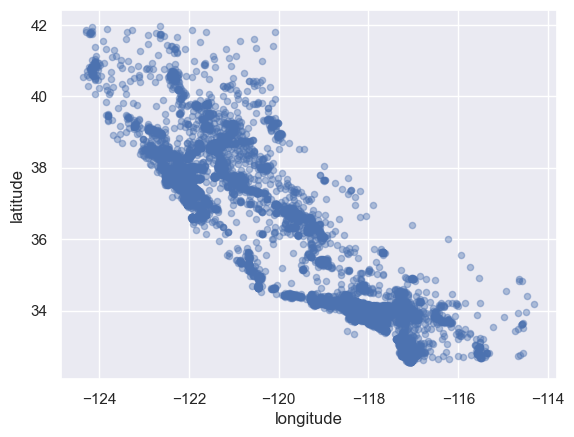

In [15]:
housing.plot(kind='scatter',  x='longitude', y='latitude', alpha=0.4)

Now, let's get a bit more insight into whether how population, and median house values are related to the location. We can use the size of marker to represent the population variable, and color to represent population variable. We choose a predefined colormap 'jet' which ranges from blue (low value) to red (high value). 

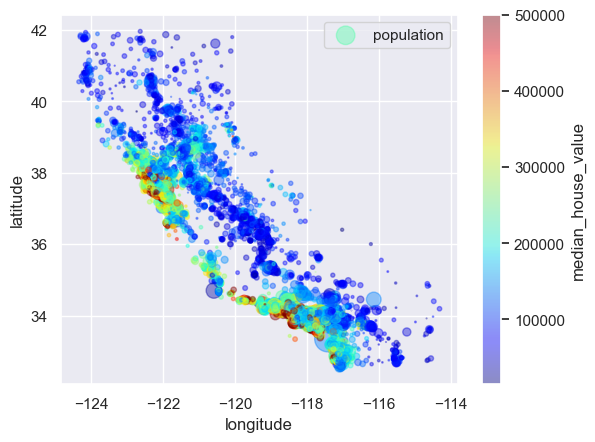

In [16]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population',
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

**Question** 

What can you conclude from this scatterplot? 

<details><summary>Click here for answer</summary>
    
This plot tells you that the housing prices are very much related to the
location (e.g., close to the ocean) and to the population density.

### Looking for Correlations

We can compute the standard correlation coefficient (Pearson's r) between every pair of attributes using the corr() method, and examine how much each attribute correlate with the median house value

In [17]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.685477
total_rooms           0.139349
housing_median_age    0.109890
households            0.068435
total_bedrooms        0.051428
population           -0.022672
longitude            -0.049594
latitude             -0.140785
Name: median_house_value, dtype: float64

**Question** 

Which variable(s) have high positive correlation with median_housing_value? 

<details><summary>Click Here for Answer</summary>

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation. In our case, median house value and median income have strong positive correlation: when median median goes up, median house value goes up as well. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to 0 mean that there is no linear correlation.
    


Another way to check for correlation between attributes is to use `sns.pairplot` function to plot every numerical attribute against every other numerical attribute.  The most promising attribute the predict the median house value seems to be the median income.  

<Figure size 1200x800 with 0 Axes>

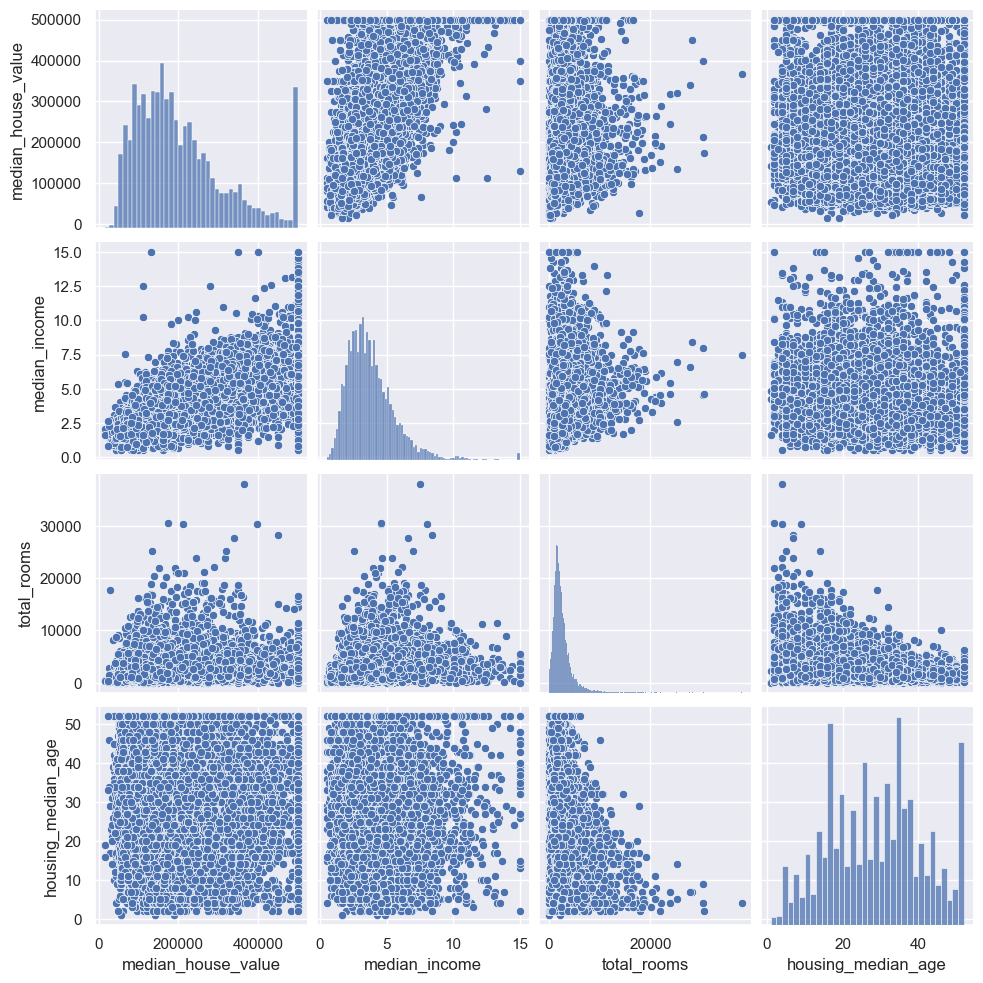

In [18]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
plt.figure(figsize=(12,8))
sns.pairplot(housing[attributes])
plt.show()

Looking at the correlation scatterplots, it seems like the most promising attribute to predict the median house value is the median income, so we zoom in on their scatterplot.

<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

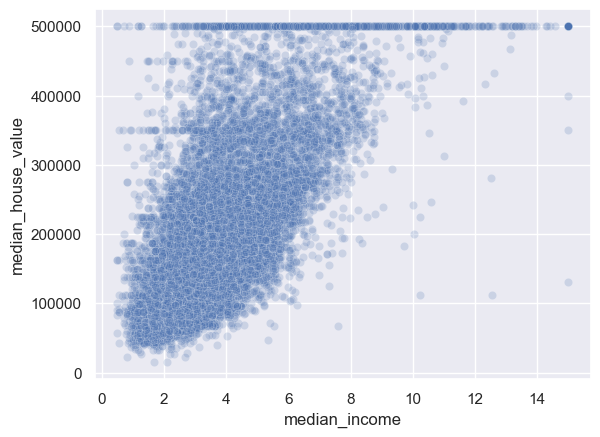

In [19]:
sns.scatterplot(data=housing, x='median_income', y='median_house_value', alpha=0.2)

**Question** 

Do you notice something peculiar about the scatter plot? 

<details><summary>Click here for answer</summary>

The price cap we noticed earlier is clearly visible as a horizontal line at \\$500,000. But the plot also reveals other less obvious straight lines: a horizontal line around \\$450,000, another around \\$350,000.

You may want to try removing the corresponding districts to prevent your algorithms from learning this data quirks.

### Experimenting with Attribute Combinations

One last thing you may want to do before preparing the data for machine learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. You create these new attributes as follows:

In [20]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

Now we look at the correlation matrix again: 

In [21]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.685477
rooms_per_household         0.148687
total_rooms                 0.139349
housing_median_age          0.109890
households                  0.068435
total_bedrooms              0.051428
population                 -0.022672
population_per_household   -0.031341
longitude                  -0.049594
latitude                   -0.140785
bedrooms_per_room          -0.262638
Name: median_house_value, dtype: float64

It looks like the new bedrooms_ratio attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district.

## Data Preparation

After gaining some understanding of our data, we are ready to prepare our data for machine learning. We will revert to our clean dataset, and separate our features (predictors) and labels (target values), i.e. the median house value. 

### Separate features and labels

In [22]:
# Separate the target values from predictors 
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels=strat_train_set['median_house_value'].copy()

### Clean the data

We observed earlier that *total_bedrooms* feature has some missing values. We can either: 
1. Get rid of the corresponding rows that has missing values for *total_bedrooms*
2. Get rid of the feature totally
3. Set the missing values to some value, which can be zero, the mean, the median, etc. This is called imputation.

Scikit Learn provides a handy class to take care of missing values: `Imputer`. 

Let's us just use the median as replacement values.  As median only make sense for numerical values, we will separate numerical features from categorical features.

In [23]:
housing_num = housing.drop('ocean_proximity', axis=1)
housing_cat =  housing['ocean_proximity']

We will then create an instance of imputer, specifying median as our replacement values, and fit (train) the imputer on our training data to learn the statistics, i.e the median.

In [24]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)
imputer.statistics_

array([-118.51 ,   34.26 ,   29.   , 2120.   ,  433.   , 1164.   ,
        408.   ,    3.536,    3.   ])

Now you can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [25]:
X = imputer.transform(housing_num)
print(X)

[[-117.62     33.43     24.     ...  367.        2.7545    2.    ]
 [-122.25     38.12     47.     ...  286.        2.5865    2.    ]
 [-122.26     37.88     52.     ...  573.        2.944     2.    ]
 ...
 [-121.32     38.7      16.     ...  480.        3.2444    3.    ]
 [-118.08     33.88     27.     ...  204.        3.825     3.    ]
 [-117.14     32.93     14.     ...  390.        4.2109    3.    ]]


Notice that after the transformation, the result is no more a dataframe, but numpy array. So let us just convert `X` back to Dataframe. 

In [26]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = housing_num.index)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 10433 to 14534
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15480 non-null  float64
 1   latitude            15480 non-null  float64
 2   housing_median_age  15480 non-null  float64
 3   total_rooms         15480 non-null  float64
 4   total_bedrooms      15480 non-null  float64
 5   population          15480 non-null  float64
 6   households          15480 non-null  float64
 7   median_income       15480 non-null  float64
 8   income_cat          15480 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


### Handling Text and Categorical Data

In this dataset, there is just one attribute that is text: the ocean_proximity attribute.  Let's just see what are the different values that this attribute has.

In [27]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     6813
INLAND        4919
NEAR OCEAN    1974
NEAR BAY      1772
ISLAND           2
Name: ocean_proximity, dtype: int64

We can see that there is only a limited number of possible values, which means this is a categorical attribute.  Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers. One way to do this is to assign a number to each category, e.g. `1<H OCEAN = 0, INLAND = 1, NEAR OCEAN = 2, etc.`. This can be done using `OrdinalEncoder()` in scikit-learn. However, one issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values, which may not be a valid assumption.  A better encoding for categorical data is to use one-hot encoding, using `OneHotEncoder()` class in scikit-learn. 
                                        

In [28]:
housing_cat

10433    NEAR OCEAN
18897      NEAR BAY
454        NEAR BAY
13127        INLAND
7564      <1H OCEAN
            ...    
8484      <1H OCEAN
5513      <1H OCEAN
12966        INLAND
7913      <1H OCEAN
14534     <1H OCEAN
Name: ocean_proximity, Length: 15480, dtype: object

In [29]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(drop="first")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.values.reshape(-1, 1))
housing_cat_1hot.toarray()

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

We can get the list of categories using the encoder’s categories_ instance variable:

In [30]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Feature Scaling and Transformation

#### Scaling 

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, machine learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Without any scaling, most models will be biased toward ignoring the median income and focusing more on the number of rooms.

There are two common ways to get all attributes to have the same scale: *min-max scaling* and *standardization*. 

In [31]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

When a feature’s distribution has a heavy tail, both min-max scaling and standardization will squash most values into a small range. Machine
learning models generally don’t like this at all. So before you scale the feature, you should first transform it to shrink the heavy tail, and if possible to make the distribution roughly symmetrical. For example, a common way to do this is to replace the feature with its logarithm.

For example, the *population* feature has a long tail. After we apply log transform, it now more closer to a Gaussian distribution.

Text(0, 0.5, 'number of districts')

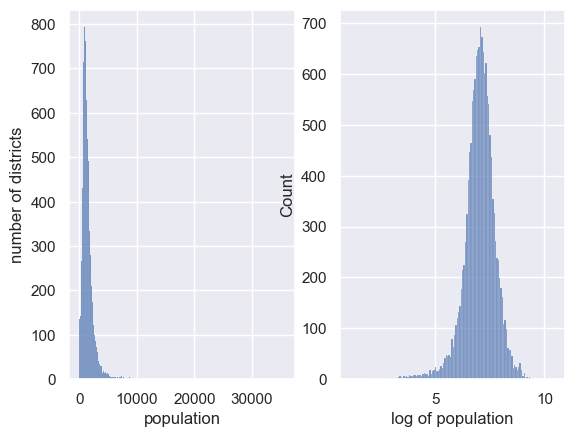

In [32]:
_, ax = plt.subplots(1,2)
sns.histplot(data=housing_tr['population'], ax=ax[0])
sns.histplot(data=housing_tr['population'].apply(np.log), ax=ax[1])
ax[0].set_xlabel('population')
ax[1].set_xlabel('log of population')
ax[0].set_ylabel("number of districts")

#### Custom Transformer

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom transformations, cleanup operations, or combining specific attributes.

For transformations that don’t require any training, you can just write a function that takes a NumPy array as input and outputs the transformed
array. For example, we can implement the log transform in the above cell as a FunctionTransformer. 

In [33]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log)

Custom transformers are also useful to combine features. For example, here’s a FunctionTransformer that computes the ratio between the input features 0 and 1.

In [34]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([ [1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

Previously, we showed that some derived features such as bedroom ratio (total_bedrooms/total_rooms) are more informative than total_bedrooms alone. Below we show how we can create a transformer for this:

In [35]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

ratio_transformer = FunctionTransformer(column_ratio, feature_names_out=ratio_name)

In [36]:
housing_rooms = housing[['total_bedrooms', 'total_rooms']]
ratio_transformer.fit_transform(housing_rooms.values)

array([[0.2962963 ],
       [0.22255414],
       [0.25560728],
       ...,
       [0.19487525],
       [0.20151679],
       [0.23792395]])

#### Transformation Pipeline

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides `make_pipeline()` to help with such sequences of transformations. Here is a small pipeline for numerical attributes, which will first impute then
scale the input features:

In [37]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

sklearn.set_config(display='diagram')  # display pipeline as diagram

# num_pipeline = Pipeline([
#     ("impute", SimpleImputer(strategy="median")),
#     ("standardize", StandardScaler()),
# ])
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

You can now use the pipeline to transform your housing_num.

In [38]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2]

array([[ 0.97524729, -1.03314092, -0.37155559, -0.6213972 , -0.36536406,
        -0.51087239, -0.34596866, -0.58776059, -0.88321373],
       [-1.3349016 ,  1.16323438,  1.45583767, -0.60129437, -0.57472881,
        -0.56105633, -0.56158185, -0.67588792, -0.88321373]])

When you call the pipeline’s `fit()` method, it calls `fit_transform()` sequentially on all the transformers, passing the
output of each call as the parameter to the next call until it reaches the final estimator, for which it just calls the `fit()` method.
The pipeline exposes the same methods as the final estimator. In this example the last estimator is a `StandardScaler`, which is a transformer, so the pipeline also acts like a transformer. If you call the pipeline’s `transform()` method, it will sequentially apply all the transformations to the data.

If you want to recover a nice DataFrame, you can use the pipeline’s `get_feature_names_out()` method:

In [39]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, 
                                       columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)

In [40]:
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
10433,0.975247,-1.033141,-0.371556,-0.621397,-0.365364,-0.510872,-0.345969,-0.587761,-0.883214
18897,-1.334902,1.163234,1.455838,-0.601294,-0.574729,-0.561056,-0.561582,-0.675888,-0.883214
454,-1.339891,1.050840,1.853097,-0.122567,0.170220,0.123596,0.202381,-0.488355,-0.883214
13127,-0.865886,1.238164,-1.007171,-0.428784,-0.348323,-0.656944,-0.316688,-1.010562,-0.883214
7564,0.690845,-0.817718,0.184608,-0.813075,-0.754880,-0.238445,-0.665396,-0.927366,-0.883214
...,...,...,...,...,...,...,...,...,...
8484,0.635960,-0.803669,0.422963,-0.267494,-0.370233,-0.145247,-0.311364,-0.451688,-0.059094
5513,0.581075,-0.770887,0.581867,-0.718171,-0.730535,-0.706231,-0.750576,-0.116017,-0.059094
12966,-0.870876,1.434854,-1.007171,0.159340,0.106924,-0.049359,-0.045175,-0.330775,-0.059094
7913,0.745729,-0.822401,-0.133200,-0.795778,-0.847390,-0.363905,-0.779857,-0.026211,-0.059094


Similarly we can define a pipeline for categorical feature:

In [41]:
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
cat_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

#### Column Transformer 

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single
transformer capable of handling all columns, applying the appropriate transformations to each column. For this, you can use a ColumnTransformer. For example, the following ColumnTransformer will apply `num_pipeline` to numerical attributes and `cat_pipeline` to categorical attribute.

In [42]:
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", 
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])
    

If we don't care about naming the individual transformer (pipeline), we can use `make_column_transformer()`: 

In [43]:
preprocessing = make_column_transformer(
                    (num_pipeline, num_attribs), 
                    (cat_pipeline, cat_attribs))

Scikit-Learn provides a `make_column_selector()` function that returns a selector function you can use to automatically select all the features of a given type, such as numerical or categorical. You can pass this selector function to the ColumnTransformer instead of column names or indices.

In [44]:
from sklearn.compose import make_column_selector 

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001AD9EEB7D30>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001AD9EEB74F0>)])

#### Integrating all the different transform pipeline

Now let us apply all the different transformations we have experimented with earlier, and put them into a single ColumnTransformer.

In [45]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

ratio_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name), 
    StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'), 
    OneHotEncoder(handle_unknown='ignore'))

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline, ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline, ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline, ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "population", "households", "median_income"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),], 
    remainder=default_num_pipeline)

preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x000001ADA1E71040>,
                                                                      func=<function column_r...
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_bedrooms', 'population', 'households',
                                  'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001AD9E643D00>)])

In [46]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(15480, 16)

In [47]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__population', 'log__households', 'log__median_income',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__longitude',
       'remainder__latitude', 'remainder__housing_median_age',
       'remainder__income_cat'], dtype=object)

In [48]:
df_housing_prepared = pd.DataFrame(housing_prepared, 
                                   columns=preprocessing.get_feature_names_out(),
                                   index=housing.index)

In [49]:
df_housing_prepared

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__income_cat
10433,1.277767,-0.788039,-0.108286,-0.134410,-0.376054,-0.098905,-0.494078,0.0,0.0,0.0,0.0,1.0,0.975247,-1.033141,-0.371556,-0.883214
18897,0.140670,-0.312700,-0.038715,-0.484016,-0.468723,-0.441084,-0.627924,0.0,0.0,0.0,1.0,0.0,-1.334902,1.163234,1.455838,-0.883214
454,0.650346,-0.543208,-0.047363,0.490114,0.447831,0.512432,-0.352568,0.0,0.0,0.0,1.0,0.0,-1.339891,1.050840,1.853097,-0.883214
13127,0.238873,-0.380170,-0.183672,-0.109501,-0.665541,-0.058381,-1.230357,0.0,1.0,0.0,0.0,0.0,-0.865886,1.238164,-1.007171,-0.883214
7564,0.607392,-0.765022,0.247921,-0.877605,0.039685,-0.642249,-1.063922,1.0,0.0,0.0,0.0,0.0,0.690845,-0.817718,0.184608,-0.883214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8484,-0.421925,-0.014886,0.042067,-0.141610,0.157014,-0.051140,-0.302659,1.0,0.0,0.0,0.0,0.0,0.635960,-0.803669,0.422963,-0.059094
5513,0.022274,-0.154335,-0.014024,-0.817383,-0.779003,-0.832639,0.106838,1.0,0.0,0.0,0.0,0.0,0.581075,-0.770887,0.581867,-0.059094
12966,-0.286136,0.305950,-0.028505,0.429444,0.268010,0.269420,-0.145917,0.0,1.0,0.0,0.0,0.0,-0.870876,1.434854,-1.007171,-0.059094
7913,-0.183724,-0.377695,0.293055,-1.133932,-0.136169,-0.904703,0.204230,1.0,0.0,0.0,0.0,0.0,0.745729,-0.822401,-0.133200,-0.059094


## Select and Train a Model

We are now ready to select and train a machine learning model. Let's train a very basic linear regression model to get started.


In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AD9E643D00>)])),
                ('linearregression', LinearRegression())])

Try it out on a few instances from the training set.  It works, but the predictions are not great!

In [51]:
housing_predictions = lin_reg.predict(housing)
print("predicted:", housing_predictions[:5].round(-2)) # -2 = rounded to the nearest hundred

print("actual:", housing_labels.iloc[:5].values)

print("diff:", housing_predictions[:5] - housing_labels.iloc[:5].values)

predicted: [186300. 177000. 202300. 120800. 111400.]
actual: [231300. 109800. 338900. 155400.  99500.]
diff: [ -45035.01810221   67181.4044696  -136600.27535556  -34616.64828194
   11865.24185535]


Let us measure the RMSE of this regression model RMSE, using scikit-learn `mean_squared_error()`.

In [52]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print(lin_rmse)

67868.8725162959


In [53]:
# housing_labels.describe()

Clearly not a great score: the median_housing_values of most districts range between \\$120,000 and \\$265,000, so a typical prediction error of \\$70,495 is really not very satisfying.

### Evaluation using Cross Validation 

Note that so far we are only evaluating the model on our training set. How do we know the performance on the test set (unseen data). One way is to a validation set. We can use the `train_test_split()` function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. 

A great alternative is to use Scikit-Learn’s *k-fold* cross-validation feature. The following code randomly splits the training set into 5
nonoverlapping subsets called folds, then it trains and evaluates the decision tree model 5 times, picking a different fold for evaluation every time and using the other 4 folds for training. The result is an array containing the 5 evaluation scores:

In [54]:
from sklearn.model_selection import cross_validate

lin_reg = make_pipeline(preprocessing, LinearRegression())
linreg_rmses = cross_validate(lin_reg, 
                              housing, 
                              housing_labels,
                              scoring="neg_root_mean_squared_error", 
                              return_train_score=True,
                              cv=5)

print("rmses (train): ", -linreg_rmses['train_score'])
print("average train rmse: ", -linreg_rmses['train_score'].mean())
print("rmses (val):", -linreg_rmses['test_score'])
print("average val rmse:", -linreg_rmses['test_score'].mean())

rmses (train):  [67246.57285689 67667.35185203 68032.40964953 68650.61702857
 67600.53367423]
average train rmse:  67839.49701224992
rmses (val): [70518.81978967 69082.61839365 67296.57694042 64729.91818864
 68991.44725416]
average val rmse: 68123.8761133063


We can try Polynomial regression by adding powers to each feature and fit a linear model on these extended features.

$$y = \beta_0+\beta_1x+\beta_2x^2+\beta_3x^3+\ldots+\beta_nx^n$$

In [55]:
from sklearn.preprocessing import PolynomialFeatures

# def column_ratio_2(X):
#      return X[:, [0]] / X[:, [1]]

# def ratio_name_2(function_transformer, feature_names_in):
#     return ["ratio"] # feature names out

# def ratio_pipeline():
#     return make_pipeline(
#         SimpleImputer(strategy="median"),
#         PolynomialFeatures(degree=2),
#         FunctionTransformer(column_ratio, feature_names_out=ratio_name),
#         StandardScaler())


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    PolynomialFeatures(degree=2),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), 
    PolynomialFeatures(degree=2),
    StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'), 
    OneHotEncoder(handle_unknown='ignore'))

preprocessing_poly = ColumnTransformer([
    ("bedrooms", ratio_pipeline, ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline, ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline, ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "population", "households", "median_income"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),], 
    remainder=default_num_pipeline)

preprocessing_poly

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('polynomialfeatures',
                                             PolynomialFeatures()),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name...
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_bedrooms', 'population', 'households',
                                  'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001ADA037D6A0>)])

In [56]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = make_pipeline(preprocessing_poly, LinearRegression())
poly_rmses = cross_validate(poly_reg, 
                            housing, 
                            housing_labels,
                            scoring="neg_root_mean_squared_error", 
                            return_train_score=True,
                            cv=3)

print("rmses (train): ", -poly_rmses['train_score'])
print("average train rmse: ", -poly_rmses['train_score'].mean())
print("rmses (val):", -poly_rmses['test_score'])
print("average val rmse:", -poly_rmses['test_score'].mean())

rmses (train):  [63555.0113844  65115.4628655  65069.84163608]
average train rmse:  64580.105295324116
rmses (val): [68949.10058349 63821.8114948  63886.12695899]
average val rmse: 65552.3463457614


We noticed that the mean train rmse has improved but the validation rmse is getting worse. This is a sign of overfitting.  We may want to try a regularized Linear regressor `Ridge`.

In [60]:
from sklearn.linear_model import Ridge

ridge_reg = make_pipeline(preprocessing_poly, Ridge())

ridge_rmses = cross_validate(ridge_reg, 
                             housing, 
                             housing_labels,
                             scoring="neg_root_mean_squared_error", 
                             return_train_score=True,
                             cv=3)

print("rmses (train): ", -ridge_rmses['train_score'])
print("average train rmse: ", -ridge_rmses['train_score'].mean())
print("rmses (val):", -ridge_rmses['test_score'])
print("average val rmse:", -ridge_rmses['test_score'].mean())

rmses (train):  [64426.1604498  66118.17715023 66007.33634244]
average train rmse:  65517.22464749212
rmses (val): [69187.03435056 64533.25136781 64792.96669496]
average val rmse: 66171.08413777889


The result looks better now. Our validation rmse is now closer to our train rmse.

We can also try other more sophisticated algorithms such as RandomForestRegressor. 

In [61]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor())

forest_rmses = cross_validate(forest_reg, 
                             housing, 
                             housing_labels,
                             scoring="neg_root_mean_squared_error", 
                             return_train_score=True,
                             cv=3)

print("rmses (train): ", -forest_rmses['train_score'])
print("average train rmse: ", -forest_rmses['train_score'].mean())
print("rmses (val):", -forest_rmses['test_score'])
print("average val rmse:", -forest_rmses['test_score'].mean())

rmses (train):  [18892.09327279 19504.79176739 19018.7984193 ]
average train rmse:  19138.56115316274
rmses (val): [53250.23856065 50697.94124758 51609.9113592 ]
average val rmse: 51852.69705581331


The training rmse is a big improvement from Linear Regression model, however, we see that there is quite a fair bit of overfitting here. Some regularization will be helpful here. 

## Model Fine Tuning

Now that we have our first model, we can try to improve the model by adjusting some of the hyper-parameters. This process is called fine-tuning. One way to fine tune the model is to use Scikit-Learn's `GridSearchCV` to evaluate all the possible combiniations of hyperparameter values that you want it to experiment with. 

In [72]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing_poly), 
    ("ridge", Ridge()),
])


param_grid = [{'ridge__alpha': [1, 30, 80]}]

grid_search = GridSearchCV(full_pipeline, 
                           param_grid, 
                           cv=3,
                           scoring='neg_root_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(housing, housing_labels)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('polynomialfeatures',
                                                                                     PolynomialFeatures()),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransform...
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001ADA037D6A0>)])),
                                       ('ridge', Ridge())]),
             param_grid=[{'ridge__alpha': [1, 30, 80]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [73]:
print('best params:', grid_search.best_params_)
print('best score:', -(grid_search.best_score_))

best params: {'ridge__alpha': 1}
best score: 66171.08413777889


In [74]:
cv_res = pd.DataFrame(grid_search.cv_results_)

cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_ridge__alpha",
                 "split0_test_score",
                 "split1_test_score", 
                 "split2_test_score", 
                 # "split3_test_score", 
                 # "split4_test_score", 
                 "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["alpha"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,alpha,split0,split1,split2,mean_test_rmse
0,1,69187,64533,64793,66171
1,30,69211,64861,65205,66426
2,80,69074,64924,65329,66442


In [75]:
# from sklearn.ensemble import RandomForestRegressor

# full_rf_pipeline = Pipeline([
#     ("preprocessing", preprocessing), 
#     ("rf", RandomForestRegressor(random_state=42)),
# ])
    
# param_grid = [
#     # try 12 (3×4) combinations of hyperparameters
#     {'rf__n_estimators': [50, 100, 200], 'rf__max_features': [2, 4, 6]},
# ]

# grid_search = GridSearchCV(full_rf_pipeline, param_grid, cv=3,
#                            scoring='neg_root_mean_squared_error',
#                            return_train_score=True)

# grid_search.fit(housing, housing_labels)

In [76]:
preprocessing.transformers

[('bedrooms',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('functiontransformer',
                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001ADA1E71040>,
                                       func=<function column_ratio at 0x000001ADA1E71430>)),
                  ('standardscaler', StandardScaler())]),
  ['total_bedrooms', 'total_rooms']),
 ('rooms_per_house',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('functiontransformer',
                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001ADA1E71040>,
                                       func=<function column_ratio at 0x000001ADA1E71430>)),
                  ('standardscaler', StandardScaler())]),
  ['total_rooms', 'households']),
 ('people_per_house',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('functiontransformer',
                   Functio

In [77]:
preprocessing_poly.transformers

[('bedrooms',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('functiontransformer',
                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001ADA1E71040>,
                                       func=<function column_ratio at 0x000001ADA1E71430>)),
                  ('standardscaler', StandardScaler())]),
  ['total_bedrooms', 'total_rooms']),
 ('rooms_per_house',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('functiontransformer',
                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001ADA1E71040>,
                                       func=<function column_ratio at 0x000001ADA1E71430>)),
                  ('standardscaler', StandardScaler())]),
  ['total_rooms', 'households']),
 ('people_per_house',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('functiontransformer',
                   Functio

In [78]:
print(grid_search.best_params_)
-grid_search.best_score_

{'ridge__alpha': 1}


66171.08413777889

In [79]:
final_model = grid_search.best_estimator_

### Evaluate System on Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. You are ready to evaluate the final model on
the test set. 

In [80]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse) # prints 41424.40026462184

66487.37720576023


## Deploy your model

We now need to get our model ready for deployment to production environment. The most basic way to do this is just to save the best model you trained, transfer the file to your production environment, and load it. To save the model, you can use the joblib library like this:

In [81]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

Once your model is transferred to production, we can load it and use it. For this we must first import any custom classes and functions the model relies on (which means transferring the code to production), then load the model using joblib and use it to make predictions:

In [84]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = X_test.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
print(predictions)
print(y_test.iloc[:5])

[ 94962.77359812 135079.15551107 199201.59435811 256695.96448636
 368836.01921907]
13631     89200.0
7557     132400.0
16238     98300.0
7129     279900.0
15623    500001.0
Name: median_house_value, dtype: float64
